# Traing ResNet 152 Classifer with Cross Vaildation 1/10

## Data Set
Testing Patients : 
* Bleeding : 15, 37, 38, 39, 60, 72, 77, 78
* Non-Bleeding : 28, 29


In [ ]:
from fastai.vision import *
import pandas as pd
from shutil import copy

path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI/")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_warp=0)

In [ ]:
strPath = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/"

In [ ]:
# Move images according to Named Patients ID
bleedingList = [15, 37, 38, 39, 60, 72, 77, 78]
nonbleedingList = [28, 29]

In [ ]:
def getTestImgList(imgList,sourceFolder,logFile):
    df = pd.read_csv(logFile,header=None )
    df.columns =['cImg','PatientID','oImg','classImg']
    cImgList = list()
    for patient_id in imgList:
        #print(patient_id)
        newdf = (df[ df['PatientID'] == " Patient "+str(patient_id) ])
        cImgList.extend( newdf['cImg'].tolist() )
    return cImgList

In [ ]:
def getTrainImgList(imgList,sourceFolder,logFile):
    df = pd.read_csv(logFile,header=None )
    df.columns =['cImg','PatientID','oImg','classImg']
    cImgList = list()
    pIDstringList = list()
    for patient_id in imgList:
        pIDstringList.append(" Patient "+str(patient_id))
    # get data frame that does not contain the testing images
    newdf = df[df['PatientID'].apply(lambda x:x not in pIDstringList)]
    cImgList =  newdf['cImg'].tolist()
    return cImgList

In [ ]:
def copyImgList(imgList,sourceFolder,destFolder):
    for img in imgList:
        copy(sourceFolder+img,destFolder)
    print("Done Copy %s Images into %s" % (imgList, destFolder))

In [ ]:
# Copy Testing nonBleeding Images into FastAI
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/test"
logFile = strPath + "processed_fastAI/log_NonBleeding.csv"
tmpList = getTestImgList(nonbleedingList,sourceFolder,logFile)
copyImgList(tmpList,sourceFolder+"nonbleeding/",destFolder)
print(len(tmpList))

In [ ]:
# Copy Testing Bleeding Images into FastAI
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/test"
logFile = strPath + "processed_fastAI/log_Bleeding.csv"
tmpList = getTestImgList(bleedingList,sourceFolder,logFile)
copyImgList(tmpList,sourceFolder+"bleeding/",destFolder)
print(len(tmpList))

In [ ]:
# Get Train Image List of nonBleedig
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/train/nonbleeding"
logFile = strPath + "processed_fastAI/log_NonBleeding.csv"
tmpList = getTrainImgList(nonbleedingList,sourceFolder,logFile)
copyImgList(tmpList,sourceFolder+"nonbleeding/",destFolder)
print(len(tmpList))

In [ ]:
# Get Train Image List of Bleedig
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/train/bleeding"
logFile = strPath + "processed_fastAI/log_Bleeding.csv"
tmpList = getTrainImgList(bleedingList,sourceFolder,logFile)
copyImgList(tmpList,sourceFolder+"bleeding/",destFolder)
print(len(tmpList))

# Training ResNet 152 Next

In [ ]:
from fastai.vision import *
import pandas as pd
from shutil import copy

path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI/train")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)
# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data = ImageDataBunch.from_folder(path,
                                  valid_pct=0.1,
                                  train='.',
                                  ds_tfms= tfms,
                                  size=224).normalize()

In [ ]:
print(data)
print(data.c)
print(data.classes)

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
img = learn.data.test_ds[0][0]

In [ ]:
img

In [ ]:
learn.predict(img)

In [ ]:
# and plot the losses of the first cycle
learn.recorder.plot_losses()

In [ ]:
# Save the finetuned model
learn.save('res34')

In [ ]:
preds,y, loss = learn.get_preds( with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])



In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
plt.savefig("roc.jpg")

# ResNet 152 Check Performance

In [ ]:
# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI/models/res152")
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(9, figsize=(10,10))
interp.plot_confusion_matrix()

In [ ]:
preds,y, loss = learner152.get_preds(with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)

In [ ]:
aa=interp.plot_confusion_matrix(return_fig=True)

In [ ]:
aa.savefig('confusion.png', dpi=300)

In [ ]:
learner152.show_results(ds_type=DatasetType.Train)

In [ ]:
learner152.show_results(ds_type=DatasetType.Test)

# Using the Testing dataset to truly test the performance of the classifer

## Need to load the `test` set as `valid` set as stated by FastAI's document

[Another approach, where you do use a normal validation set, and then when the training is over, you just want to validate the test set w/ labels as a validation set, you can do this:](https://docs.fast.ai/data_block.html#LabelLists.add_test_folder)

```python

tfms = []
path = Path('data').resolve()
data = (ImageList.from_folder(path)
        .split_by_pct()
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize() ) 
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5,1e-2)

# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.validate(data_test.valid_dl)

```

In [29]:
from fastai.vision import *
import pandas as pd
from shutil import copy

path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI_TestASValid")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=224).normalize()

In [30]:
print(data_test)

ImageDataBunch;

Train: LabelList (1089 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI_TestASValid;

Valid: LabelList (73 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/fastAI_TestASValid;

Test: None


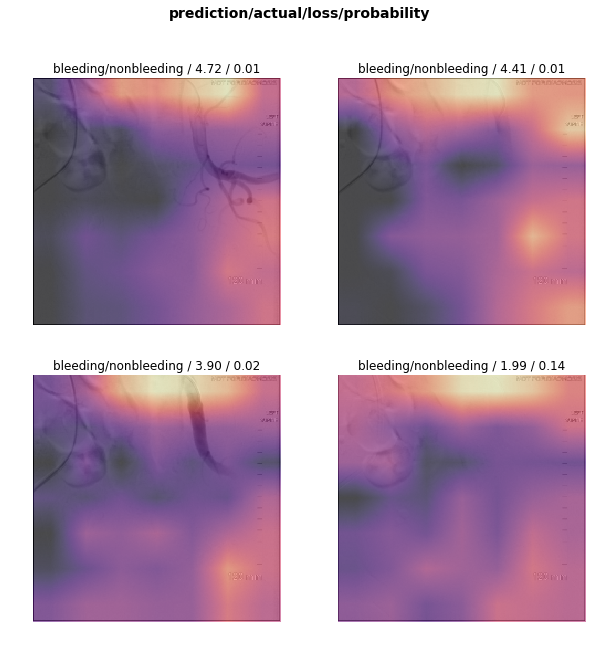

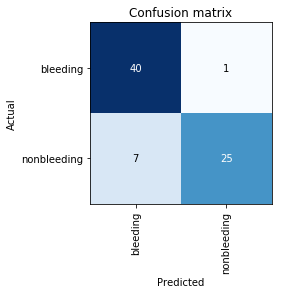

In [32]:
# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/models/res152")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion.png', dpi=300)

In [34]:
preds,y, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)

TypeError: get_preds() got an unexpected keyword argument 'with_dropout'

In [15]:
re = list()
for pred in preds:
    if pred[0] > pred[1]:
        re.append(0)
    else:
        re.append(1)

In [20]:
re_y = y.tolist()

In [21]:
acc

tensor(0.9256)

In [22]:
(re -re_y)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [26]:
len(preds)

1089

In [36]:
learner152.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

## The End

In [1]:
## Calculate Basic Statics


In [2]:
# Get Train Image List of Bleedig
strPath = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/"
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/train/bleeding"
logFile = strPath + "processed_fastAI/log_Bleeding.csv"

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(logFile,header=None )
df.columns =['cImg','PatientID','oImg','classImg']
df.head

<bound method NDFrame.head of                  cImg       PatientID           oImg  classImg
0      bleeding.1.jpg   Patient 79_34   79_16_34.tif         1
1      bleeding.2.jpg   Patient 79_34   79_20_34.tif         1
2      bleeding.3.jpg   Patient 79_34   79_18_34.tif         1
3      bleeding.4.jpg   Patient 79_34   79_30_34.tif         1
4      bleeding.5.jpg   Patient 79_34   79_33_34.tif         1
5      bleeding.6.jpg   Patient 79_34   79_23_34.tif         1
6      bleeding.7.jpg   Patient 79_34   79_27_34.tif         1
7      bleeding.8.jpg     Patient 31A      31_21.tif         1
8      bleeding.9.jpg     Patient 31A      31_35.tif         1
9     bleeding.10.jpg     Patient 32A       32_6.tif         1
10    bleeding.11.jpg     Patient 32A      32_31.tif         1
11    bleeding.12.jpg      Patient 45       45_9.tif         1
12    bleeding.13.jpg      Patient 45      45_13.tif         1
13    bleeding.14.jpg      Patient 45      45_17.tif         1
14    bleeding.15.jpg    

In [5]:
df['PatientID']

0       Patient 79_34
1       Patient 79_34
2       Patient 79_34
3       Patient 79_34
4       Patient 79_34
5       Patient 79_34
6       Patient 79_34
7         Patient 31A
8         Patient 31A
9         Patient 32A
10        Patient 32A
11         Patient 45
12         Patient 45
13         Patient 45
14         Patient 45
15         Patient 45
16         Patient 45
17         Patient 45
18         Patient 45
19         Patient 45
20         Patient 45
21         Patient 45
22         Patient 42
23         Patient 42
24         Patient 42
25         Patient 42
26         Patient 42
27         Patient 42
28         Patient 42
29         Patient 42
            ...      
742       Patient 39B
743       Patient 38B
744       Patient 38B
745       Patient 38B
746       Patient 38B
747       Patient 38B
748       Patient 38B
749       Patient 38B
750       Patient 38B
751       Patient 38B
752       Patient 38B
753       Patient 38B
754       Patient 38B
755       Patient 38B
756       

In [7]:
pIDList = df['PatientID'].tolist()

In [9]:
len(set(pIDList))

73

In [10]:
# Get Train Image List of Bleedig
strPath = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet6/"
sourceFolder = strPath + "processed_fastAI/"
destFolder = strPath + "fastAI/train/bleeding"
logFile = strPath + "processed_fastAI/log_NonBleeding.csv"
df = pd.read_csv(logFile,header=None )
df.columns =['cImg','PatientID','oImg','classImg']
df.head

<bound method NDFrame.head of                     cImg    PatientID        oImg  classImg
0      nonbleeding.1.jpg   Patient 27    27_3.tif         0
1      nonbleeding.2.jpg   Patient 27    27_2.tif         0
2      nonbleeding.3.jpg   Patient 27    27_1.tif         0
3      nonbleeding.4.jpg   Patient 27    27_5.tif         0
4      nonbleeding.5.jpg   Patient 27    27_4.tif         0
5      nonbleeding.6.jpg   Patient 27    27_6.tif         0
6      nonbleeding.7.jpg   Patient 27    27_7.tif         0
7      nonbleeding.8.jpg    Patient 7     7_8.tif         0
8      nonbleeding.9.jpg    Patient 7    7_16.tif         0
9     nonbleeding.10.jpg    Patient 7    7_14.tif         0
10    nonbleeding.11.jpg    Patient 7    7_28.tif         0
11    nonbleeding.12.jpg    Patient 7    7_12.tif         0
12    nonbleeding.13.jpg    Patient 7    7_22.tif         0
13    nonbleeding.14.jpg    Patient 7    7_20.tif         0
14    nonbleeding.15.jpg    Patient 7    7_34.tif         0
15    nonb

In [11]:
pIDList = df['PatientID'].tolist()
len(set(pIDList))

23